### 1. Importing dependencies

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from mlpr_pipe_configs import RConfig
import json

### 2. Reading train and test sets and preprocessing

In [2]:
train_df = pd.read_csv("../../data/regression_data/regression_train.csv")
test_df  = pd.read_csv("../../data/regression_data/regression_test.csv")

In [3]:
train_df.shape

(1042, 8)

#### 2.1 Cleaning the data

The dataset contains 7 predictive features and the target one.
This sample below already tells us the target feature contains null values. To address this issue, we shall drop these null rows as they are unlabeled and we cannot label them without previous knowledge of the data.

In [4]:
train_df.sample(5)

,target,X1,X2,X3,X4,X5,X6,X7
339,511.790908,2.152593,0.231116,47.882672,0.948153,-61.371619,5,0.543122
731,NaN,-1.539720,-0.303435,49.127816,5.692228,-68.353487,0,-0.713073
152,426.639319,-0.940464,0.831225,49.741246,3.182386,-56.903822,8,1.953378
729,NaN,5.276440,5.467457,46.555648,0.100142,-66.344296,0,12.848524
515,NaN,6.043276,-3.644253,51.639051,0.002360,-45.817489,0,-8.563994


In [5]:
train_df = train_df[train_df.target.isnull() == False]
test_df = test_df[test_df.target.isnull() == False]

Now, the data we have is ready to be fed into the pipeline, as it is clean and all feature values are numbers.

In [6]:
train_df.dtypes

target    float64
X1        float64
X2        float64
X3        float64
X4        float64
X5        float64
X6          int64
X7        float64
dtype: object

In [7]:
train_df.isnull().sum()

target    0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
dtype: int64

#### 2.2 Split both train and test sets into X feature matrix and y target vector

In [9]:
y_train = train_df.target
X_train = train_df.drop(columns=['target'])

y_test = test_df.target
X_test = test_df.drop(columns=['target'])

In [10]:
X_train.shape

(715, 7)

In [11]:
X_test.shape

(180, 7)

### 3. Training the regressor: Multilayer Perceptron Regressor (MLPRegressor)

#### 3.1 Defining the pipeline
Using pipelines, we can automate some tasks as scaling and dtype transformation. In this case, we only need to take care of feature scaling. The estimator is first defaultly defined so that we can fine tune later.

In [12]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('estimator', MLPRegressor(random_state=42, max_iter=1000))
])

pipe.fit(X_train, y_train)

C:\Users\wssf\Documents\PROJETOS\chall-ds\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator', MLPRegressor(max_iter=1000, random_state=42))])

Gathering the metrics for the default model to further evaluation and discussion.

In [13]:
y_pred_train = pipe.predict(X_train)

train_metrics = {'values': [mean_squared_error(y_train, y_pred_train, squared=False),
                      r2_score(y_train, y_pred_train),
                      pearsonr(y_pred_train, y_train).statistic],
           'scorer': ['RMSE', 'R2', 'correlation'],
           'estimator': 'default',
           'dataset': 'train'}

In [14]:
y_pred_test = pipe.predict(X_test)

test_metrics = {'values': [mean_squared_error(y_test, y_pred_test, squared=False),
                      r2_score(y_test, y_pred_test),
                      pearsonr(y_pred_test, y_test).statistic],
           'scorer': ['RMSE', 'R2', 'correlation'],
           'estimator': 'default',
           'dataset': 'test'}

#### 3.2 Using GridSearchCV

Instantiating the GridSearchCV configuration class.

In [15]:
config = RConfig()

Defining the GridSearchCV over the pipeline previously stated. The parameters from the GradientBoostingClassifier to be fine tuned are defined in 'mlpr_pipe_configs', as well as the scores. The refitting is called so that the 'r2_score' is considered primordial when fitting the 5 folds for each candidate estimator in the search.

In [16]:
mlp_gscv = GridSearchCV(estimator=pipe, param_grid=config.params, verbose=True, scoring=config.scores, refit='r2').fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Now, GridSearchCV has stated that this is the best estimator for the set of parameters we have selected for fine tuning. We get then its results to further comparison.

In [17]:
nn = mlp_gscv.best_estimator_

In [18]:
nn.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator',
                 MLPRegressor(alpha=1e-05, batch_size=32,
                              hidden_layer_sizes=(64, 32, 16),
                              learning_rate_init=0.01, max_iter=1000,
                              random_state=42))])

In [19]:
y_pred_train = nn.predict(X_train)

train_metrics_cv = {'values': [mean_squared_error(y_train, y_pred_train, squared=False),
                      r2_score(y_train, y_pred_train),
                      pearsonr(y_pred_train, y_train).statistic],
           'scorer': ['RMSE', 'R2', 'correlation'],
           'estimator': 'fine-tuned',
           'dataset': 'train'}

In [20]:
y_pred_test = nn.predict(X_test)

test_metrics_cv = {'values': [mean_squared_error(y_test, y_pred_test, squared=False),
                      r2_score(y_test, y_pred_test),
                      pearsonr(y_pred_test, y_test).statistic],
           'scorer': ['RMSE', 'R2', 'correlation'],
           'estimator': 'fine-tuned',
           'dataset': 'test'}

#### 3.3 Showing the results

In [21]:
metrics = pd.concat([pd.DataFrame(train_metrics_cv), pd.DataFrame(test_metrics_cv), pd.DataFrame(train_metrics), pd.DataFrame(test_metrics)])

In [22]:
metrics.sort_values(by=['scorer', 'estimator'], ascending=True)

,values,scorer,estimator,dataset
1,0.555187,R2,default,train
1,0.570180,R2,default,test
1,0.999952,R2,fine-tuned,train
1,0.999960,R2,fine-tuned,test
0,1061.830611,RMSE,default,train
0,828.188748,RMSE,default,test
0,11.024953,RMSE,fine-tuned,train
0,8.018074,RMSE,fine-tuned,test
2,0.942893,correlation,default,train
2,0.942296,correlation,default,test


The results show us the fine tuned model improves very significantly the RMSE score, close to 100x better on the test set. Considering this score as the evaluation metric for this regressor, R2 and the correlation become two satisficing scores. R2 and correlation for the fine tuned model show that it explains approximately 99% of the relationship between predictive features and target one (compared to 57% on the default regressor) as well as the predicted results are strongly and linearly related to the label results as indicated the correlation close to 1.

It is also fair to say that with the default regressor, the model underfits the data as the performance even on the training set ir poor. But after fine tuning we see good results and it is not a case of overfitting.

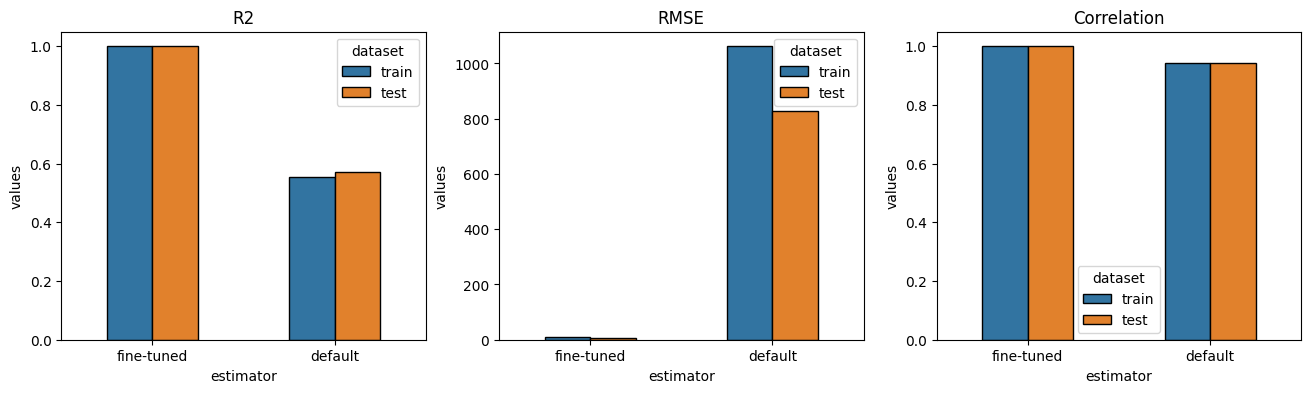

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(16,4))

sns.barplot(data=metrics[metrics.scorer == 'R2'], x='estimator', y='values', hue='dataset', width=.5, edgecolor='black', ax=ax[0])
sns.barplot(data=metrics[metrics.scorer == 'RMSE'], x='estimator', y='values', hue='dataset', width=.5, edgecolor='black', ax=ax[1])
sns.barplot(data=metrics[metrics.scorer == 'correlation'], x='estimator', y='values', hue='dataset', width=.5, edgecolor='black', ax=ax[2])

ax[0].set_title("R2")
ax[1].set_title("RMSE")
ax[2].set_title("Correlation")
plt.show()

#### 3.4 Visualizing the loss curve for MLPRegressor (MSE)

In [24]:
sk_history = nn[1].loss_curve_

When entering the epoch 75, the models loss decreases slowly until it early stops close to the epoch 175.

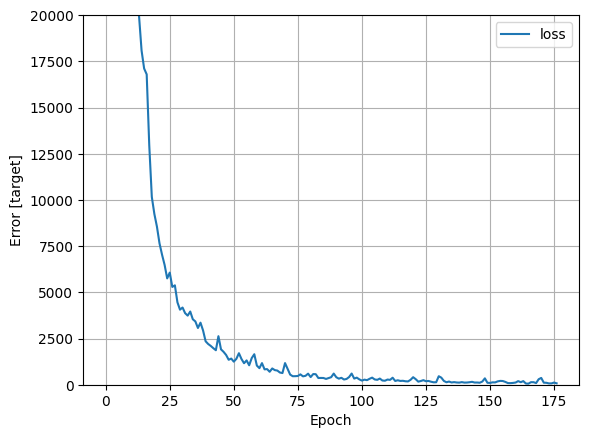

In [25]:
plt.plot(sk_history, label='loss')
plt.ylim([0, 20000])
plt.xlabel('Epoch')
plt.ylabel('Error [target]')
plt.legend()
plt.grid(True)

### 4. Analysing features importances and predictive power

#### 4.1 Permutation importance

This algorithm from scikit-learn compares the scores from permutating the features columns in comparison to some baseline metric.

After executing it, the mean values for the 'importance' of the features in terms of prediction is defined.

In [26]:
features_importances = permutation_importance(nn, X_train, y_train, n_repeats=10, random_state=42)

These results point to <strong>X2</strong> and <strong>X7</strong> as the variables with more predictive power over the target.

In [27]:
features_importances.importances_mean

array([6.67242393e-02, 4.16555778e-01, 8.17797192e-03, 1.20146507e-02,
       2.22003667e-05, 5.93702146e-06, 4.40434059e-01])

It is visible the difference in how the features behave individually in terms of target. As <strong>X5</strong> and <strong>X6</strong> are the ones with less importance to target, their behaviour is much more unordered.

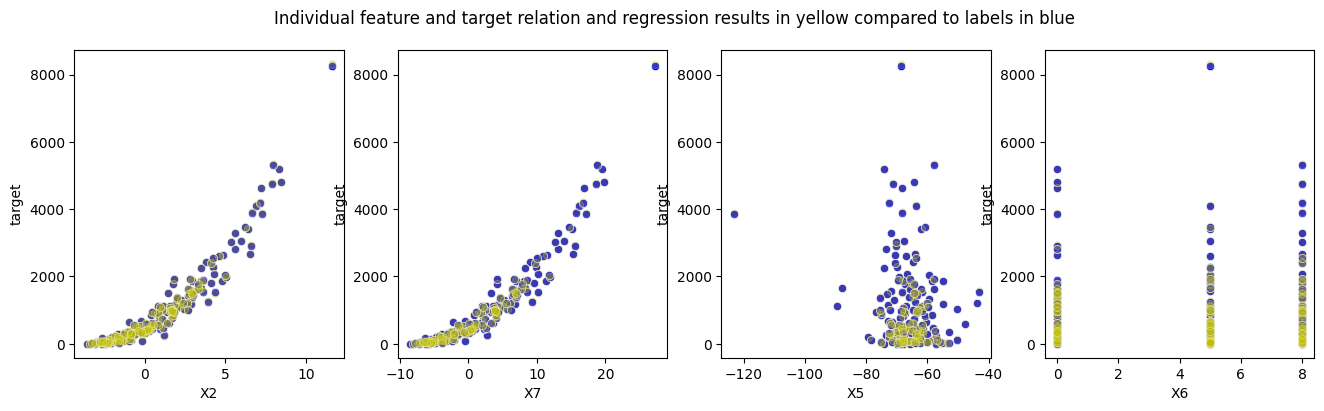

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(16,4))
sns.scatterplot(data=test_df, x='X2', y='target', ax=ax[0], color='b')
sns.scatterplot(data=test_df, x='X2', y=y_pred_test, ax=ax[0], alpha=0.4, color='y')

sns.scatterplot(data=test_df, x='X7', y='target', ax=ax[1], color='b')
sns.scatterplot(data=test_df, x='X7', y=y_pred_test, ax=ax[1], alpha=0.3, color='y')

sns.scatterplot(data=test_df, x='X5', y='target', ax=ax[2], color='b')
sns.scatterplot(data=test_df, x='X5', y=y_pred_test, ax=ax[2], alpha=0.3, color='y')

sns.scatterplot(data=test_df, x='X6', y='target', ax=ax[3], color='b')
sns.scatterplot(data=test_df, x='X6', y=y_pred_test, ax=ax[3], alpha=0.3, color='y')

fig.suptitle("Individual feature and target relation and regression results in yellow compared to labels in blue")
plt.show()

#### 4.2 Using Partial Dependency Analysis

This technique defines the average response of the regressor estimator for each possible value from each feature in the set of predictive ones.

These results match with the previous analysis using feature importances. The regressor has more partial dependence in both <strong>X2</strong> and <strong>X7</strong> compared to the others. We can see this as we go through the values for these two features, the average response of the regressor increases more significantly.

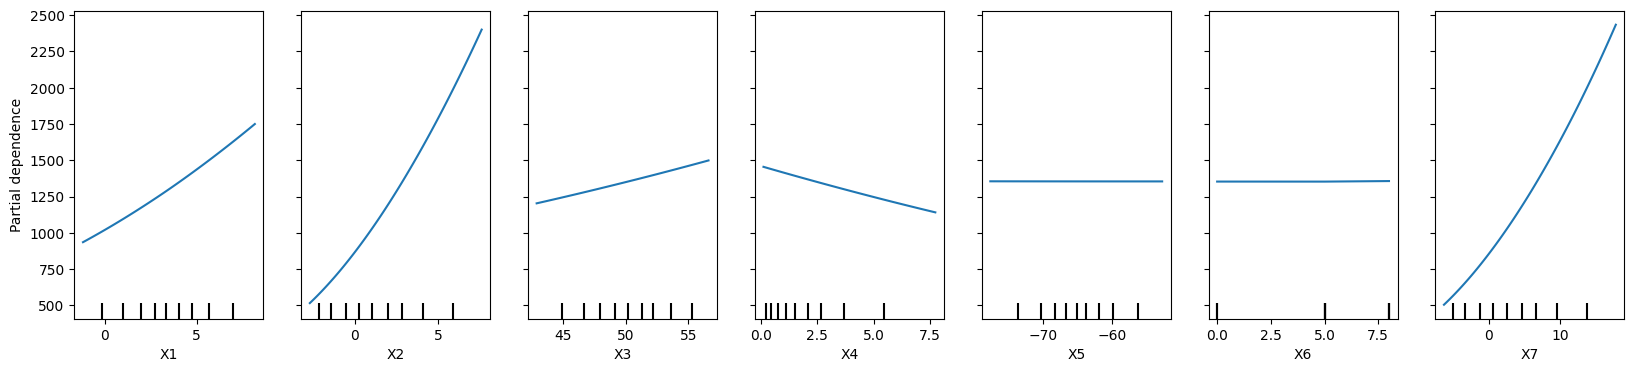

In [29]:
fig, ax = plt.subplots(figsize=(20,4))
PartialDependenceDisplay.from_estimator(nn, X_train, ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7'], n_cols=7, ax=ax)
plt.show()

#### 4.3 Correlation over the training dataset

Understanding this heatmap also confirms previous analysis. <strong>X2</strong> and <strong>X7</strong> are the ones with the highest correlation with the target feature, meaning these two features are strongly related to target. 

<Axes: >

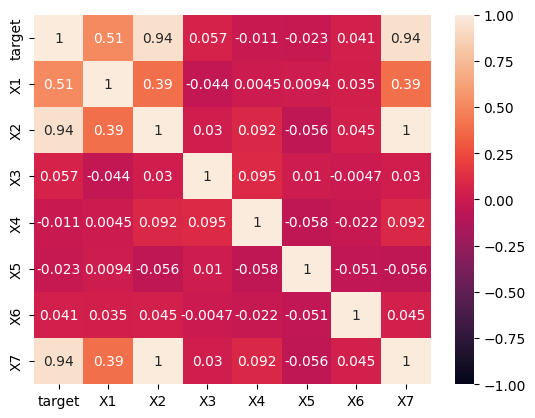

In [30]:
sns.heatmap(train_df.corr(), annot=True, vmin=-1, vmax=1)

### 5. Dumping the model so that it can be loaded from the API builded

In [31]:
pickle.dump(nn, open('../../app/models/regressor.pkl', 'wb'))